<a href="https://colab.research.google.com/github/francesco-source/DeepLearning/blob/main/9_autoencoders_and_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we build a simple auotencoder for Mnist data, and show how to use it for anomaly detection.

In [25]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Both the encoder and the decoder are just composed by a couple of dense layers.
The latent dimension is 16. This means that each input is reduced from an initial dimensions of 28*28=784 to a an internal dimension of just 16 floats.

Most of the relevant information is preserved, as testified by the fact that we are able to reconstruct, out of this 16 values, an image very similar to the original one.

In [26]:
# size of our encoded representations
encoding_dim = 8
mid_dim = 128 #intermidiete dimension

# input placeholder
input_img = layers.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded_1 = layers.Dense(mid_dim, activation='relu')(input_img)
encoded_2 = layers.Dense(32,activation = "relu")(encoded_1)
encoded_3 = layers.Dense(encoding_dim, activation='relu')(encoded_2)
# "decoded" is the lossy reconstruction of the input, they must be simmetric respect to the encoder.
decoded_1 = layers.Dense(32, activation = "relu")(encoded_3)
decoded_2 = layers.Dense(mid_dim, activation='relu')(decoded_1)
decoded_3 = layers.Dense(784, activation='sigmoid')(decoded_2)

# this model maps an input to its reconstruction
autoencoder= Model(input_img, decoded_3)

In [27]:
autoencoder.summary()#we have a pregressive reduction of dimension and then we extend it again in order to exctract information again.

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_43 (Dense)            (None, 128)               100480    
                                                                 
 dense_44 (Dense)            (None, 32)                4128      
                                                                 
 dense_45 (Dense)            (None, 8)                 264       
                                                                 
 dense_46 (Dense)            (None, 32)                288       
                                                                 
 dense_47 (Dense)            (None, 128)               4224      
                                                                 
 dense_48 (Dense)            (None, 784)               1011

We can now compile the model. 

As loss function we can take mse or categorical crossentropy, as you prefer. 

In [30]:
adam = Adam(learning_rate=0.001)#learning rate
autoencoder.compile(optimizer=adam, loss='mse')#the loss

We now load the datatet, and normalize it in the range [0,1]. We are not using labels.

In [31]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# we nromalize and flatten the data.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Time to fit the model. Observe that the ground truth we need to compare with is in this case the input itself. In other words, the loss is the distance between the inout $X$ and its reconstruction $\hat{X}$

In [32]:
# the fitting operation we use the training data also as label. 
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/20
235/235 [==============================] - 4s 8ms/step - loss: 0.0726 - val_loss: 0.0530
Epoch 2/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0493 - val_loss: 0.0433
Epoch 3/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0406 - val_loss: 0.0375
Epoch 4/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0360 - val_loss: 0.0346
Epoch 5/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0340 - val_loss: 0.0331
Epoch 6/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0328 - val_loss: 0.0322
Epoch 7/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0318 - val_loss: 0.0310
Epoch 8/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0304 - val_loss: 0.0296
Epoch 9/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0294 - val_loss: 0.0288
Epoch 10/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0287 - val_loss: 0.0283

Let us check the result.

First of all we conpute all reconstructions for images in the test set.

In [34]:
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 1s 2ms/step


Now we can plot the result. We pick ten random images, and for each of them we show the original and the reconstruction obtained from the autoencoder.

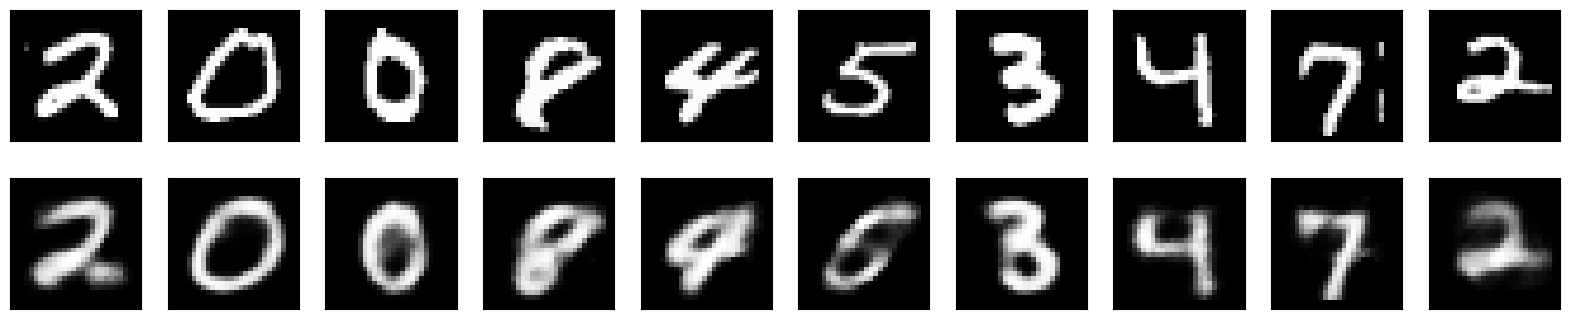

In [37]:
import matplotlib.pyplot as plt

n = 10 #no images to plot
imgs = np.random.randint(low=0,high=10000,size=n)
plt.figure(figsize=(20, 4))
for (i,idx) in enumerate(imgs):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
#noe perfect but the compression was aggressive because we passed from 784 to 8. 

# Anomaly detection

We want now to show how we can use an autoencoder for anomaly detection.

The genral idea is that the encoding learned by the autoenoder is data-specific. This means that if we apply the autoencoder to an outlier, the resulting reconstruction should be sensibily worse than usual, and we may exploit this simple fact to detect the anomaly.

The first step of the procedure is to identify the canonical expected reconstruction error on true data, and the associated standard deviation.

In [38]:
mse_all = np.mean(np.square(decoded_imgs - x_test),axis=1) #mean error for each input
print(mse_all.shape) 
mse = np.mean(mse_all)
std = np.std(mse_all)
print("mse is {}, with a standard deviation of {}".format(mse,std))

(10000,)
mse is 0.02428998053073883, with a standard deviation of 0.012674313969910145


Now we create an "anomaly". We simply take a normal image from the dataset, and rotate it of 90 degrees. 

For this example, we use image no 15 in the test set.

1/1 [==============================] - 0s 36ms/step - loss: 0.0322
0.0321650393307209


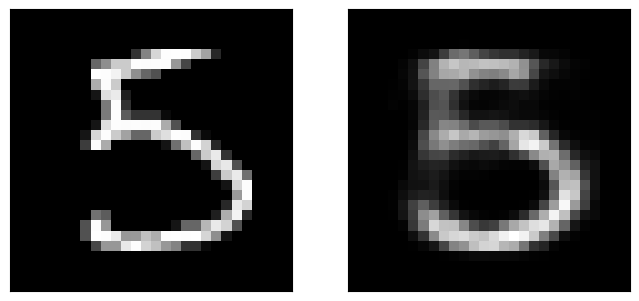

In [39]:
test = x_test[15].reshape(1,784)
print(autoencoder.evaluate(test,test))

plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
plt.imshow(x_test[15].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1, 2, 2)
plt.imshow(decoded_imgs[15].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('lyar1.jpg')
plt.show()

Observe that the reconstruction is not particularly good, but still the loss (0.207) is more or less on std away from the mean, that is a normal behaviour.

Now, let us rotate it and repeat the computation.

1/1 [==============================] - 0s 18ms/step


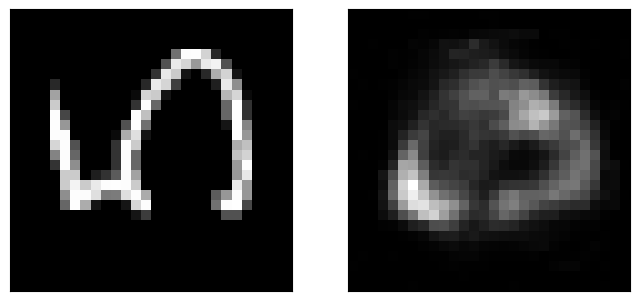

In [40]:
rotated = np.rot90(x_test[15].reshape(28,28))
predicted = autoencoder.predict(rotated.reshape(1,784))[0].reshape(28,28)

plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
plt.imshow(rotated)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1, 2, 2)
plt.imshow(predicted)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('lyar2.jpg')
plt.show()
# doen't look anymore similar to that 5. This is what it's produces. the error of the reconstruction is very height. We are 3 standard deviations avay from the mean value of the error.
# We can say that this is an oulier. Something that the net has never seen before. Effective technique to detect outliers, this is becausw it was trained to detect mnist digits.
#Other applications are denoising. 

In [41]:
mse = np.mean(np.square(predicted-rotated))
print("mse is {}".format(mse))

mse is 0.06466783583164215


The mse in this case is 0.052, more than 3 std away form the mean, that is surely an anomaly!!

Let us finally observe that, instead of using mean and variance of reconstruction errors, we could have directly worked in the latent space.

In fact, autoencoders generalize Principal Component Ananlysis, extracting relevant, non linear combinations of the input features. Any anomaly will 
sensibibly discost from canonical values of the latent encoding.